In [1]:
import sys; sys.path.append("..")

import tqdm
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# plotting helper
def plot_one(df, ax, ylim=None, s=20, add_label=False):
    df = df.copy().reindex() 
    if ylim is None: ylim = (df.drop('x',axis=1).min().min(), df.drop('x',axis=1).max().max())
    
    inf_pis = (df['hi'] == np.inf) | (df['lo'] == - np.inf)
    
    df['hi'] = df['hi'].replace(np.inf, ylim[1] + 1)
    df['lo'] = df['lo'].replace(-np.inf, ylim[0] - 1)
    
    miss_idx = df.index[((df['y'] < df['lo']) | (df['y'] > df['hi']))]

    miss_y = df.loc[miss_idx, 'y']
    miss_x = df.loc[miss_idx, 'x']
    ax.scatter(miss_x, miss_y, label='missed y' if add_label else None, alpha=0.5, s=s, c='red', marker='x')

    #scatter plot covered
    cover_idx = df.index[((df['y'] >= df['lo']) & (df['y'] <= df['hi']))]
    covered_y = df.loc[cover_idx,'y']
    covered_x = df.loc[cover_idx, 'x']
    if False:
        label = f'covered ({len(cover_idx) / len(df) * 100:.1f}%)'
    else:
        label = f'covered y'
    ax.scatter(covered_x, covered_y, label=label if add_label else None, alpha=0.5, s=s, c='gray', marker='.')
    
    ax.plot(df['x'], df['yhat'], color='black', label='$\hat{y}$' if add_label else None)
    ax.fill_between(df['x'], df['lo'], df['hi'], color='blue', alpha=.1, label='PI' if add_label else None)#, label=f'{prefix}[{lq}, {uq}]')
    for idx in df.index[inf_pis]:
        ax.fill_between([df.loc[idx,'x'] + _ for _ in [-0.5, 0.5]], [ylim[0] - 1]*2, [ylim[1] + 1]*2, color='red', alpha=.1, label='inf PI' if add_label else None)#, label=f'{prefix}[{lq}, {uq}]')
        add_label = False
    ax.set_ylim(*ylim)
    ax.set_xlabel(f'Coverage: {len(cover_idx) / len(df) * 100:.1f}%')
    ax.legend()

# Step 1 (Data): GEFCom energy load data
Since the health data requires license, we will be using GEFCom as a simply example for TQA.

In [3]:
import data.preprocessing.gefc as gefc
df = gefc.read_data().dropna().drop('date', axis=1)

# normalize the data using the training set
n_train, n_calibration, n_test = 1198, 200, 700
horizon = 24
df = (df - df.iloc[:(n_train*horizon)].mean()) / df.iloc[:(n_train * horizon)].std()

# define the X and Y
df['pred_LOAD'] = df['LOAD'].shift(1)
Y = np.expand_dims(df['LOAD'].iloc[1:].values, 1)
X = df.reindex(columns=['pred_LOAD'] + ['w%d'%(i+1) for i in range(25)]).iloc[1:].values

# split the data into 24-hour sequcens
Xs, Ys = [], []
for y_st in range(horizon - 1, len(df) - 1, horizon):
    Ys.append(Y[y_st:y_st+horizon])
    Xs.append(X[y_st: y_st + horizon])
    
# permute the data
perm = np.random.RandomState(seed=42).permutation(n_train + n_calibration + n_test)
Xs = [Xs[i] for i in perm]
Ys = [Ys[i] for i in perm]

In [4]:
# example the data we need. Xs and Ys are list of np.ndarrays
len(Xs), Xs[0].shape, len(Ys), Ys[0].shape

(2098, (24, 26), 2098, (24, 1))

Let's finally put the data prepared above into a `Dataset` object, like before, using `DatasetWrapperFull`.

In [5]:
from data.online_dataset import DatasetWrapperFull
train_dataset = DatasetWrapperFull(Xs[:n_train], Ys[:n_train], max_full_length=horizon)
calibration_dataset = DatasetWrapperFull(Xs[n_train:n_train+n_calibration], Ys[n_train:n_train+n_calibration], max_full_length=horizon)
test_dataset = DatasetWrapperFull(Xs[n_train+n_calibration:], Ys[n_train+n_calibration:], max_full_length=horizon)

# Step 2 (Base Model): LSTM
We fit a LSTM on the time series data like usual. 

In [6]:
def _get_lengths_mask(sequences, lengths):
    lengths_mask = torch.zeros_like(sequences, device=sequences.device)
    for i, l in enumerate(lengths): lengths_mask[i, -l:, :] = 1
    return lengths_mask

class DemoRNN(torch.nn.Module):
    def __init__(self, embedding_size, input_size):
        super(DemoRNN, self).__init__()
        self.forecaster_rnn = torch.nn.LSTM(input_size=input_size, hidden_size=embedding_size, batch_first=True)
        self.forecaster_out = torch.nn.Linear(embedding_size, 1)

    def forward(self, x,state=None):
        return self.forecaster_out(self.forecaster_rnn(x.float())[0])

    def fit(self, train_dataset, batch_size, epochs, lr, device='cuda:0'):
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.MSELoss(reduction='mean')
        self.train()
        for epoch in tqdm.tqdm(range(epochs), desc='Training..'):
            for sequences, targets, lengths_input, lengths_target in train_loader:
                optimizer.zero_grad()
                out = self((sequences * _get_lengths_mask(sequences, lengths_input)).to(device))
                targets = targets.to(device)
                criterion(out * _get_lengths_mask(out, lengths_target), targets * _get_lengths_mask(targets, lengths_target)).backward()
                optimizer.step()
        return self

In [7]:
# Change the following parameters if necessary for faster experiment
device = 'cuda:0'
epochs = 1000

# fit the model
model = DemoRNN(embedding_size=32, input_size = train_dataset[0][0].shape[1]).to(device)
model = model.fit(train_dataset, batch_size=128, epochs=epochs, lr=1e-3, device=device)

Training..: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.35it/s]


In [8]:
# we need the model to predict Y given X, like below:
model(torch.unsqueeze(train_dataset[0][0],0).to(device))

tensor([[[-0.5326],
         [-0.7346],
         [-0.8298],
         [-0.9021],
         [-0.8729],
         [-0.7696],
         [-0.4008],
         [-0.1797],
         [-0.0883],
         [ 0.1273],
         [ 0.3855],
         [ 0.6759],
         [ 0.9233],
         [ 1.1338],
         [ 1.3779],
         [ 1.3872],
         [ 1.5285],
         [ 1.4695],
         [ 1.2087],
         [ 1.0810],
         [ 1.1737],
         [ 0.6920],
         [ 0.2644],
         [-0.1934]]], device='cuda:0', grad_fn=<AddBackward0>)

# Step 3: TQA

In [9]:
import models.tqa as tqa
cal_model = tqa.TQA_B(model)
cal_model.calibrate(calibration_dataset, device=device)

In [10]:
# retrieve a batch of test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False)
x,y, _, _ = next(iter(test_loader))

# To make prediction, we do the following:
# Here, we passed y to *predict* for simplicity, because we will use information up to time t-1 when we make the prediction for time t
yhat, pi = cal_model.predict(x.to(device), y.to(device),alpha=0.1)[:2]

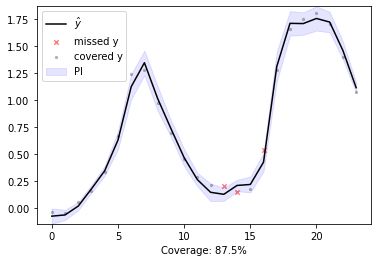

In [15]:
# let's look at one example
idx = 7

tdf = pd.DataFrame({k: v[:,0].cpu().numpy() for k,v in {"y": y[idx], "yhat": yhat[idx], 'lo': pi[idx,0], 'hi': pi[idx,1]}.items()})
tdf = tdf.reset_index().rename(columns={"index":'x'})
plot_one(tdf, ax=plt.subplots()[1], add_label=True)

### Remark:
This notebook only serves as a tutorial on how to use TQA for any existing pipeline.
You could replace Step 1 and 2 with any data and model you have.
To replicate other experiments/results, please still refer to `main.ipynb`.